# Optimization of DAMIC CCDs Using Machine Learning

### Goal

This document will follow the development of a program which will be used to optimize DAMIC CCDs using machine learning.  The program will use Alex Piers' code to find relevant variables which can be used to determine the quality of any given image.  It will be able to map these parameters which determine the images' quality to the input parameters used to configure the CCD or to combinations of the parameters.  This will help identify which parameters or combinations of parameters are most relevant to image quality, which will allow us to build a model for image quality using machine learning.  Once we have a method for creating good models, we should be able to use it to optimize CCDs.

### Convirt .fits files to .csv

To make analysis of these input and output variables, we don't want to be moving around all the raw data for each image since we will only be using processed data.  That means the first step will be to make a csv file for each CCD, containing the input and output variables of each image.  Later analysis will be done using the csv file.

The cell below runs FitsToCSV.py on the specified directory and all subdirectories it contains.  If the data is outside the folder, the argument should be the whole filepath to get to the directory.  Directories should be of the form "UW(4 digits)S" or "YYYY-MM-DD".  It will convirt every Img+//.fits file contained in the directory or subdirectories into a line in the csv output file.  The program may take several minutes to compile, depending on how large the directory is that one is analyzing.

In [1]:
!python FitsToCSV.py "UW1032S"

UW1032S
  0%|                                                     | 0/4 [00:00<?, ?it/s]Reading images from: UW1032S
/home/shda/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.75s/it]


### Graphing Variables (1 Dimensional)

The first analysis we want to see from the .csv file is the relation between 2 variables.  The code cell below takes two variable names as arguments, and shows the relation between them in a scatter plot.  The first argument will be the .csv file, the second argument will be the variable appearing on the x axis, and the third will appear on the y.

Key to Variables:

Inputs:
'EXP', 'AMPL', 'HCKDIRN', 'VCKDIRN', 'ITGTIME', 'VIDGAIN', 'PRETIME', 'POSTIME', 'DGWIDTH', 'RGWIDTH', 'OGWIDTH', 'SWWIDTH', 'HWIDTH', 'HOWIDTH', 'VWIDTH', 'VOWIDTH', 'ONEVCKHI', 'ONEVCKLO', 'TWOVCKHI', 'TWOVCKLO', 'TGHI', 'TGLO', 'HUHI', 'HULO', 'HLHI', 'HLLO', 'RGHI', 'RGLO', 'SWLO', 'DGHI', 'DGLO', 'OGHI', 'OGLO', 'BATTR', 'VDD1', 'VDD2', 'DRAIN1', 'DRAIN2', 'VREF1', 'VREF2', 'OPG1', 'OPG2'.

Outputs:
'imgNoise', 'skNoise', 'aveImgS', 'dSdskip', 'pixVar', 'clustVar', 'tailRatio', 'DC'.

Image info:
'NDCMS', 'NAXIS1', 'NAXIS2'.

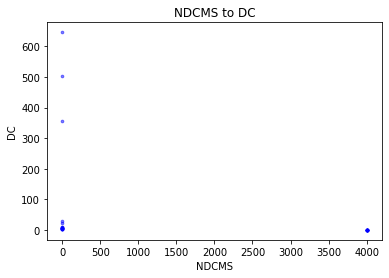

In [2]:
%matplotlib inline
import Graphing

Graphing.graph1D("2020-02-02.csv","NDCMS", 0, 40000, "DC", 0 , 50)

### Transform CSV For Further Analysis

Make a new .csv file which convirts image quality into one single metric, which consists of the magnitude of a vector whos components are dark current, noise, and charge transfer, each multiplied by a scalar which decides the weighting of each component.  

In [5]:
import TransformCSV

fileTransform = "2020-02-02.csv"

TransformCSV.transformCSV(fileTransform, "T-" + fileTransform)

### Finding Correlations Between Variables

To get a better idea about how variables affect each other, we need a way to look at correlations between variables, which turns out to be relativley straight forward using pandas.

In [5]:
import pandas as pd

ccd = pd.read_csv("T-2020-02-02.csv")
ccd.corr()['imgQuality'].sort_values()

NDCMS        -2.773801e-01
NAXIS1       -2.773801e-01
TGHI         -1.806801e-01
VOWIDTH      -1.006233e-16
VWIDTH       -1.006233e-16
SWWIDTH      -1.006233e-16
RGWIDTH      -1.006233e-16
OGWIDTH      -1.006233e-16
POSTIME      -1.006233e-16
PRETIME      -1.006233e-16
DGWIDTH      -1.006233e-16
ITGTIME      -3.417394e-17
OPG1          3.417394e-17
HULO          3.417394e-17
HLLO          3.417394e-17
OPG2          3.417394e-17
NAXIS2        2.773801e-01
VREF1         3.290345e-01
VREF2         3.290345e-01
imgQuality    1.000000e+00
EXP                    NaN
VCKDIRN                NaN
VIDGAIN                NaN
HWIDTH                 NaN
HOWIDTH                NaN
ONEVCKHI               NaN
ONEVCKLO               NaN
TWOVCKHI               NaN
TWOVCKLO               NaN
TGLO                   NaN
HUHI                   NaN
HLHI                   NaN
RGHI                   NaN
RGLO                   NaN
SWLO                   NaN
DGHI                   NaN
DGLO                   NaN
O